In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sibulator import *

In [2]:
fbi_samples = pd.read_csv('fbi_dataset.csv').rename({'THO1':'TH01', 'THO1.1':'TH01.1'}, axis=1)
with open('fbi_dataset_metadata.json', 'r') as f:
    metadata = json.load(f)

In [3]:
fbi_samples.head()

,ID#,D3S1358,D3S1358.1,vWA,vWA.1,FGA,FGA.1,D8S1179,D8S1179.1,D21S11,...,LDLR,LDLR.1,GYPA,GYPA.1,HBGG,HBGG.1,D7S8,D7S8.1,Gc,Gc.1
0,B0600,15.0,17,15,16,23.0,27.0,12,13,28.0,...,B,B,A,A,B,B,A,A,B,B
1,B0601,14.0,15,16,16,23.0,24.0,14,17,28.0,...,A,B,A,B,A,B,A,A,B,B
2,B0602,15.0,15,16,17,24.0,25.0,11,13,30.0,...,B,B,A,B,A,B,A,A,B,C
3,B0603,16.0,16,17,18,21.0,22.0,11,14,27.0,...,A,A,A,A,A,B,A,B,B,C
4,B0604,14.0,14,14,14,20.0,27.0,12,15,29.0,...,B,B,A,A,A,B,A,B,C,C


In [4]:
metadata

{'AFRICAN AMERICAN': 210,
 'U.S. CAUCASIAN': 203,
 'SOUTHWESTERN HISPANIC': 209,
 'BAHAMIAN': 162,
 'JAMAICAN': 244,
 'TRINIDADIAN': 85}

In [5]:
starting_idx = np.cumsum([0] + list(metadata.values()))
starting_idx

array([   0,  210,  413,  622,  784, 1028, 1113])

In [6]:
float_cols = []
for col in fbi_samples:
    try:
        fbi_samples[col] = fbi_samples[col].astype(float)
        if '.1' not in col:
            float_cols.append(col)
    except:
        print(col)
float_cols = float_cols[:-1]
print(len(float_cols)) # number of loci

ID#
HLA-DQA1
HLA-DQA1.1
LDLR
LDLR.1
GYPA
GYPA.1
HBGG
HBGG.1
D7S8
D7S8.1
Gc
Gc.1
13


In [7]:
known_samples = []
for i, row in fbi_samples.iterrows():
    sample = {}
    for col in float_cols:
        sample[col] = row[[col, col + '.1']].values.tolist()
    known_samples.append(sample)

In [16]:
len(allele_freq.keys())

23

In [11]:
use_freq = 'nist'
allele_freq = load_allele_frequencies(use_freq)
overlaps_by_subpop = {}
for i, subpop in enumerate(metadata.keys()):
    print(subpop)
    if subpop == 'AFRICAN AMERICAN':
        subpop = 'AfAm'
    elif subpop == 'U.S. CAUCASIAN':
        subpop = 'Cauc'
    elif subpop == 'SOUTHWESTERN HISPANIC':
        subpop = 'Hisp'
    else:
        continue
        
    start_idx = starting_idx[i]
    end_idx = starting_idx[i+1]
    subpop_samples = known_samples[start_idx:end_idx]
    sample_overlaps = []
    for sample in subpop_samples:
        sim_sample = generate_one_sample(sample, allele_freq, subpop)
        
        overlap = 0
        for k in sample.keys():
            ks_alleles = sample[k]
            ss_alleles = sim_sample[k]
            overlap_conditions = [ks_alleles[0] == ss_alleles[0], # first ones same
                                  ks_alleles[1] == ss_alleles[1], # second ones same
                                  ks_alleles[0] == ss_alleles[1] and not ks_alleles[0] == ks_alleles[1], # first is same as second, hetero
                                  ks_alleles[1] == ss_alleles[0] and not ks_alleles[0] == ks_alleles[1]] # second is same as first, hetero
            # print(ks_alleles[0], ks_alleles[1], ss_alleles[0], ss_alleles[1])
            overlap +=  np.sum(overlap_conditions)
        sample_overlaps.append( overlap )
    overlaps_by_subpop[subpop] = sample_overlaps
# for sample in known_samples[:10]:
#     sample = generate_sibling_samples(known_sample, use_freq, subpop, num_siblings)

AFRICAN AMERICAN
U.S. CAUCASIAN
SOUTHWESTERN HISPANIC
BAHAMIAN
JAMAICAN
TRINIDADIAN


210
203
209


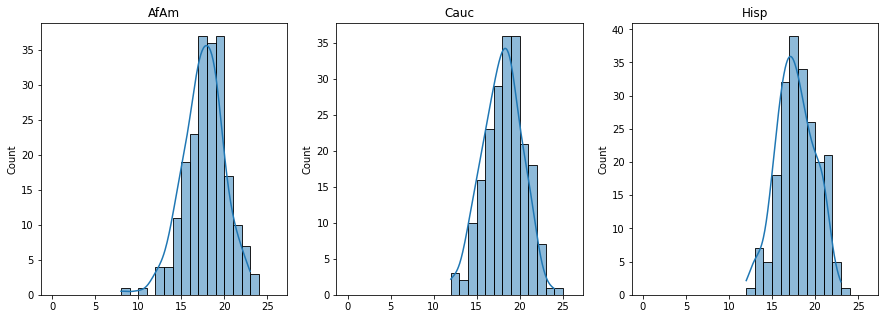

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flat
for i, (k, v) in enumerate(overlaps_by_subpop.items()):
    print(len(v))
    sns.histplot(v, bins=np.linspace(0,26,27), kde=True, ax=axes[i])
    axes[i].set_title(k)
plt.show()

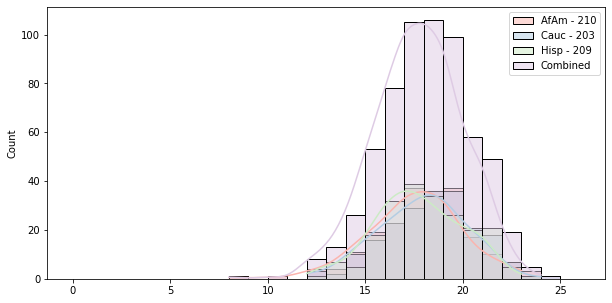

In [14]:
combined_overlaps = []
for k, v in overlaps_by_subpop.items():
    combined_overlaps += v

plt.figure(figsize=(10,5))
for i, (k, v) in enumerate(overlaps_by_subpop.items()):
    sns.histplot(v, bins=np.linspace(0,26,27), kde=True, color=plt.cm.Pastel1(i), label='{} - {}'.format(k, len(v)))
sns.histplot(combined_overlaps, bins=np.linspace(0,26,27), kde=True, color=plt.cm.Pastel1(3), label='Combined')
plt.legend()
plt.show()